# Collision based method

/opt/miniconda3/envs/py39/lib/python3.9/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
/opt/miniconda3/envs/py39/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


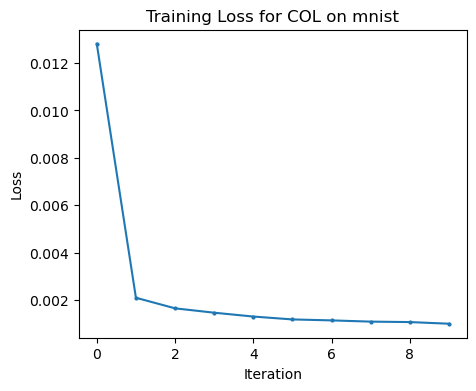

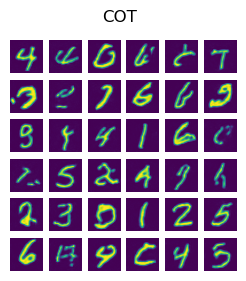

In [1]:
from pathlib import Path
import sys

# Go up one directory from the notebook’s folder
root_dir = Path().resolve().parent
sys.path.insert(0, str(root_dir))

from src.colOT.col import *
from src.prerpoc import *
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download

device = "cpu"

name_dataset = "mnist"
#name_dataset = "CIFAR10"
#name_dataset = "Food101"

repo_id = "mohsensadr91/"+name_dataset     # your repo name on Hugging Face
filename = "col_MNIST_10kSamples_10Epochs_1e-4Lr.pt"  # must match the filename you uploaded
#filename = "col_CIFAR10.pt"  # must match the filename you uploaded
#filename = "col_Food101_75kSamples_10Epochs_1e-4Lr.pt"  # must match the filename you uploaded


# Download checkpoint file from Hub (caches locally after first time)
checkpoint_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    local_dir="../models",        # 👈 forces saving in your folder
    local_dir_use_symlinks=False  # avoids symlinks to cache
)

checkpoint = torch.load(checkpoint_path, map_location=device)
params = checkpoint["model_params"]

model = Unet(
    dim=params["dim"],
    channels=params["channels"],
    dim_mults=params["dim_mults"],
    flash_attn=params["flash_attn"],
    learned_variance=params["learned_variance"],
)

image_size = params["image_size"]
num_channel = params["channels"]
col = MyCOL(model, device=device, num_timesteps=params["timesteps"])

col.load_state_dict(checkpoint["model_state"])

col.eval()

#################
col_loss_hist = checkpoint["hist_loss"]
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figsize as needed
ax.plot(col_loss_hist, marker='o', markersize=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title(f"Training Loss for COL on {name_dataset}")
#plt.savefig("col_"+name_dataset+"_loss.pdf", dpi=300, bbox_inches='tight', pad_inches=0)

nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3, 3))  # Adjust figsize as needed
fig.suptitle("COT", fontsize=12)

k=0
for i in range(nrows):
    for j in range(ncols):
        x = torch.randn((1, num_channel, image_size[0], image_size[1])).to(device)
        x = torch.clamp((col.sample(x) + 1) / 2, 0, 1)

        x = x.detach().cpu().numpy()[0, ...].T
        x = np.swapaxes(x,0,1)
        ax[i, j].imshow(x)
        ax[i, j].axis('off')  # Turn off ticks and labels
        k += 1

plt.subplots_adjust(wspace=0, hspace=0.2)
fig.savefig("col_"+name_dataset+".png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

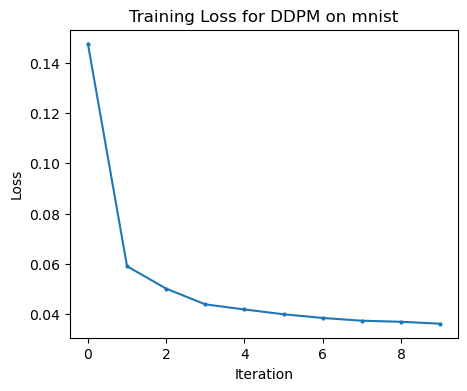

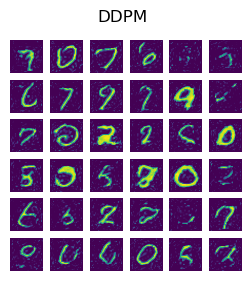

In [2]:
from src.ddpm.ddpm import *
from src.prerpoc import *
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download

device = "cpu"

name_dataset = "mnist"
#name_dataset = "CIFAR10"
#name_dataset = "Food101"

repo_id = "mohsensadr91/"+name_dataset     # your repo name on Hugging Face
filename = "ddpm_MNIST_10kSamples_10Epochs_1e-4Lr.pt"  # must match the filename you uploaded
#filename = "ddpm_CIFAR10.pt"  # must match the filename you uploaded
#filename = "ddpm_Food101_75kSamples_10Epochs_1e-4Lr.pt"  # must match the filename you uploaded

# Download checkpoint file from Hub (caches locally after first time)
checkpoint_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    local_dir="../models",        # 👈 forces saving in your folder
    local_dir_use_symlinks=False  # avoids symlinks to cache
)

checkpoint = torch.load(checkpoint_path, map_location=device)
params = checkpoint["model_params"]

model = Unet(
    dim=params["dim"],
    channels=params["channels"],
    dim_mults=params["dim_mults"],
    flash_attn=params["flash_attn"],
    learned_variance=params["learned_variance"],
)

diffusion = GaussianDiffusion(
    model.to(device),
    image_size=params["image_size"],
    timesteps=params["timesteps"]
)

diffusion.load_state_dict(checkpoint["model_state"])

diffusion.to(device)

diffusion.eval()

ddpm_loss_hist = checkpoint["hist_loss"]

#################
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figsize as needed
ax.plot(ddpm_loss_hist, marker='o', markersize=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title(f"Training Loss for DDPM on {name_dataset}")
#plt.savefig("ddpm_"+name_dataset+"_loss.pdf", dpi=300, bbox_inches='tight', pad_inches=0)

nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3, 3))  # Adjust figsize as needed
fig.suptitle("DDPM", fontsize=12)

k=0
for i in range(nrows):
    x0 = diffusion.sample(batch_size = ncols).detach().cpu().numpy()
    for j in range(ncols):
        x = x0[j, ...].T
        x = np.swapaxes(x,0,1)
        ax[i, j].imshow(x)
        ax[i, j].axis('off')  # Turn off ticks and labels
        k += 1


plt.savefig("ddpm_"+name_dataset+".png", dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()


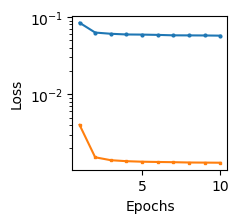

In [3]:
its = [i+1 for i in range(len(ddpm_loss_hist))]
fig, ax = plt.subplots(figsize=(2, 2))  # Adjust figsize as needed
ax.plot(its, ddpm_loss_hist, marker='o', markersize=2)
ax.plot(its, col_loss_hist, marker='s', markersize=2)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
plt.savefig(name_dataset+"_loss.png", dpi=300, bbox_inches='tight', pad_inches=0)

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

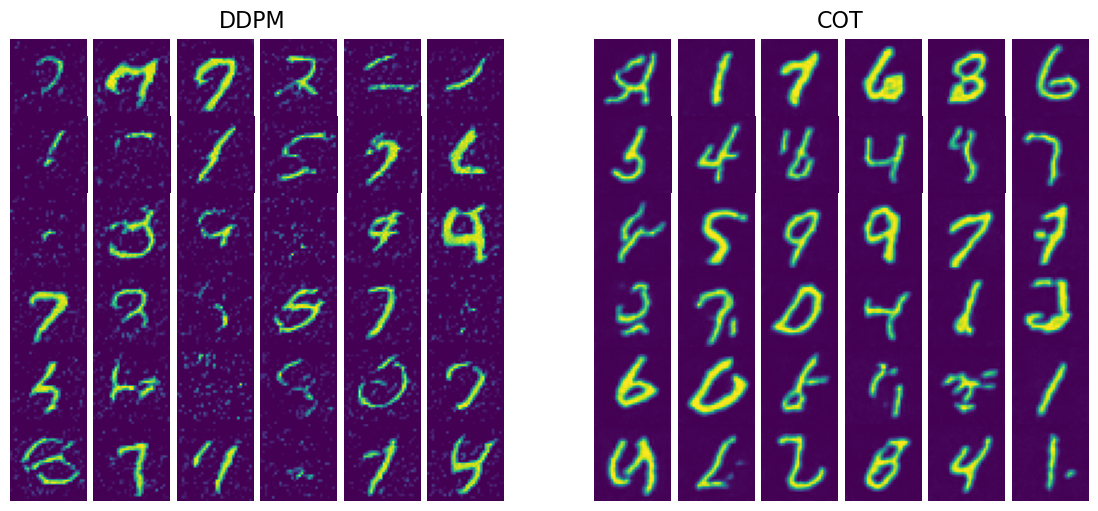

In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import torch

nrows, ncols = 6, 6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols*2+1, figsize=(14, 6))  # wider figure

fig.subplots_adjust(wspace=0, hspace=0)  # remove all spacing

# -----------------------
# Left: DDPM
# -----------------------

for i in range(nrows):
    x0 = diffusion.sample(batch_size=ncols).detach().cpu().numpy()
    for j in range(ncols):
        x = x0[j, ...].T
        x = np.swapaxes(x, 0, 1)
        axes[i, j].imshow(x)
        axes[i, j].axis('off')

# Title for left grid
fig.text(0.3, 0.9, "DDPM", fontsize=16, ha='center')

# -----------------------
# Right: COT
# -----------------------

for i in range(nrows):
    for j in range(ncols):
        x = torch.randn((1, num_channel, image_size[0], image_size[1])).to(device)
        x = torch.clamp((col.sample(x) + 1) / 2, 0, 1)
        x = x.detach().cpu().numpy()[0, ...].T
        x = np.swapaxes(x, 0, 1)
        axes[i, j + ncols+1].imshow(x)
        axes[i, j + ncols+1].axis('off')

# Title for right grid
fig.text(0.72, 0.9, "COT", fontsize=16, ha='center')

# Hide spacer column
for i in range(nrows):
    axes[i, ncols].axis('off')

plt.savefig("combined_"+name_dataset+".png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/miniconda3/envs/py39/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

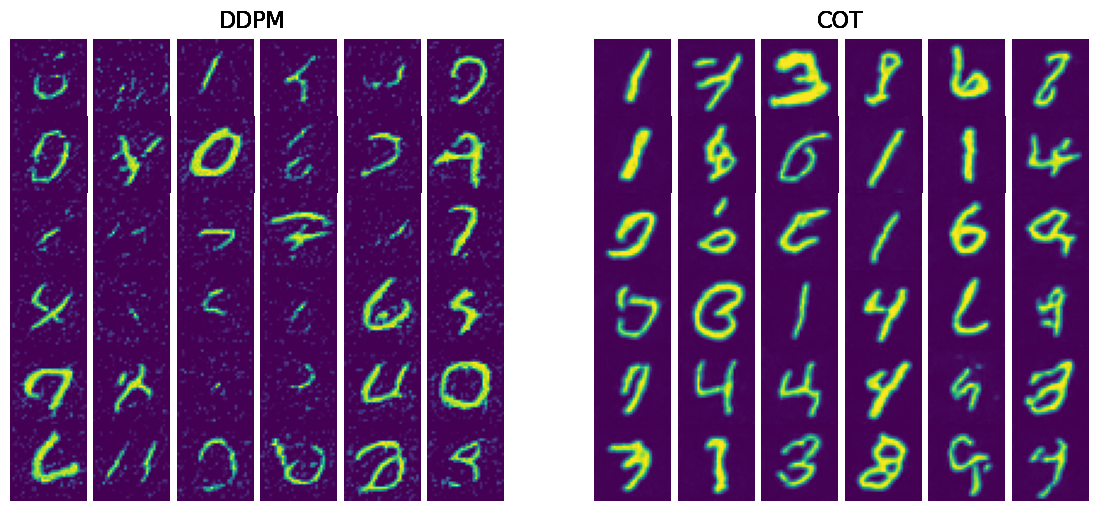

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch

nrows, ncols = 6, 6
n_frames = 8   # number of pages/frames in the gif

fig, axes = plt.subplots(nrows=nrows, ncols=ncols*2+1, figsize=(14, 6))
fig.subplots_adjust(wspace=0, hspace=0)

def update(frame_idx):
    # -----------------------
    # Left: DDPM
    # -----------------------
    for i in range(nrows):
        x0 = diffusion.sample(batch_size=ncols).detach().cpu().numpy()
        for j in range(ncols):
            x = x0[j, ...].T
            x = np.swapaxes(x, 0, 1)
            axes[i, j].imshow(x)
            axes[i, j].axis('off')

    # -----------------------
    # Right: COT
    # -----------------------
    for i in range(nrows):
        for j in range(ncols):
            x = torch.randn((1, num_channel, image_size[0], image_size[1])).to(device)
            x = torch.clamp((col.sample(x) + 1) / 2, 0, 1)
            x = x.detach().cpu().numpy()[0, ...].T
            x = np.swapaxes(x, 0, 1)
            axes[i, j + ncols + 1].imshow(x)
            axes[i, j + ncols + 1].axis('off')

    # Spacer column hidden
    for i in range(nrows):
        axes[i, ncols].axis('off')

    # Titles
    fig.text(0.3, 0.9, "DDPM", fontsize=16, ha='center')
    fig.text(0.72, 0.9, "COT", fontsize=16, ha='center')

# Create animation
ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=400, repeat=True)

# Save as GIF (good for websites)
ani.save("combined_"+name_dataset+".gif", writer="pillow", dpi=120)

plt.show()
